# 프로젝트: 한국어 데이터로 챗봇 만들기

In [1]:
import tensorflow as tf

print(tf.__version__)

2025-10-14 15:33:40.282744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760456020.531972      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760456020.599651      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


과정 개요
___

Step 1. 데이터 수집하기
- 한국어 챗봇 데이터는 [송영숙님이 공개한 챗봇 데이터](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)를 사용합니다.

Step 2. 데이터 전처리하기
- 영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

Step 3. SubwordTextEncoder 사용하기
- 한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

Step 4. 모델 구성하기
- 위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

Step 5. 모델 평가하기
- Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

## Step 1. 데이터 수집하기
- 한국어 챗봇 데이터는 [송영숙님이 공개한 챗봇 데이터](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)를 사용합니다.

In [2]:
# 데이터 받아오기
!wget https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv

import pandas as pd

chatbot_data = pd.read_csv('ChatbotData.csv')
display(chatbot_data.head())

--2025-10-14 15:33:54--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData.csv’

ChatbotData.csv     100%[===================>] 868.99K  --.-KB/s    in 0.05s   

2025-10-14 15:33:54 (18.4 MB/s) - ‘ChatbotData.csv’ saved [889842/889842]



,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
# 쳇봇데이터 크기
chatbot_data.shape

(11823, 3)

<Axes: title={'center': 'Distribution of sentence length of A'}, ylabel='Frequency'>

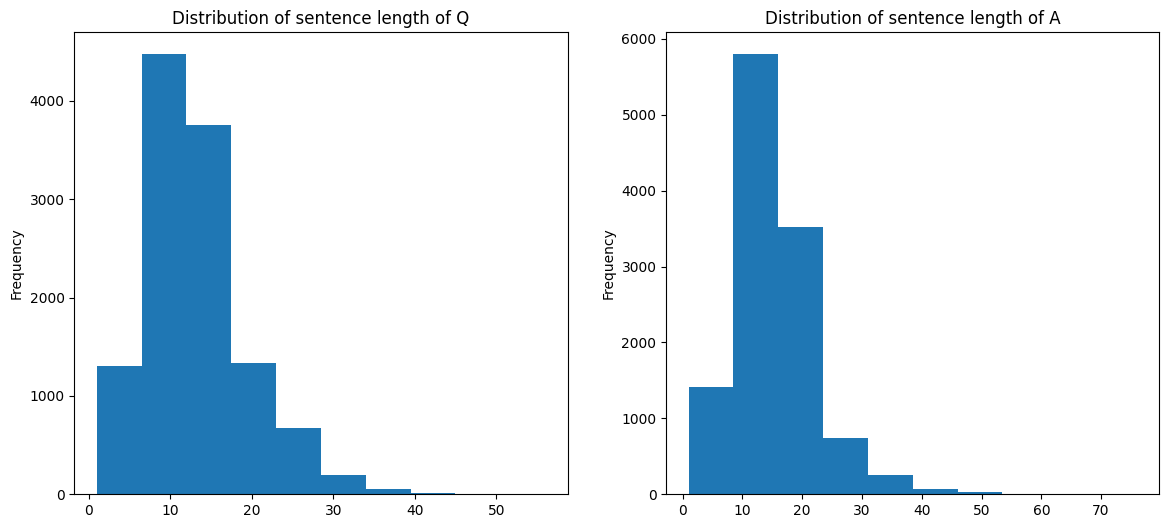

In [4]:
# 문장 길이 분포
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.subplot(121)
chatbot_data.Q.apply(lambda x: len(x)).plot(kind='hist', title='Distribution of sentence length of Q')

plt.subplot(122)
chatbot_data.A.apply(lambda x: len(x)).plot(kind='hist', title='Distribution of sentence length of A')

## Step 2. 데이터 전처리하기
- 원활한 토큰화 작업을 위한 데이터 전처리 작업을 수행하였습니다.
- 세부 내용
  - `양쪽 공백 제거`, `다양한 형태의 구두점 통일`, `연속되는 문장 부호 처리`, `특수문자 제거`, `문장 부호 주위 공백 추가`, `연속 공백 처리` 등


### check_varied_punctuation(sentence)

In [5]:
# 다양한 형태의 구두점 포함 여부 확인 함수
import re

def check_varied_punctuation(sentence):
    # 다양한 형태의 따옴표, 대시, 줄임표 등을 찾는 패턴
    varied_punctuation_pattern = r"['\"`‘’“”‒–—―~…]"
    return re.search(varied_punctuation_pattern, sentence) is not None

# 데이터셋에서 다양한 형태의 구두점이 포함된 문장 예시 출력
print("구두점 확인 Q column:")
count_q = 0
for sentence in chatbot_data['Q']:
    if check_varied_punctuation(sentence):
        print(f"Q: {sentence}")

print("\n구두점 확인 A column:")
count_a = 0
for sentence in chatbot_data['A']:
    if check_varied_punctuation(sentence):
        print(f"A: {sentence}")

구두점 확인 Q column:
Q: 나는 좋은데 ….
Q: 떠나요~ 제주도~
Q: 바람쐬러 정동진가~~
Q: 스트레스~
Q: 와인 한잔 짠~
Q: 으으~ 떨린다
Q: 15년…안녕
Q: 같이 보고싶어서 올려~
Q: 나는 좋은데 ….
Q: 비많이오네~
Q: 삼십대를 훌러덩~~~~
Q: 소식이 궁금해~
Q: 속시원해~~안녕 잘가~~~
Q: 아휴~ 싱숭생숭한 하루
Q: 여자친구 만나고왔어~
Q: 오늘도출근해~
Q: 완전히 끝났어~
Q: 요즘은 솔로인게 좋네~!!
Q: 윤종신 '좋니' 노래 가사가 엄청 와닿네
Q: 이것 또한 받아들이는 것이겠죠~??
Q: 이런 여자.이런남자.안대용~
Q: 이야기를 한번 해보려 합니다~
Q: 자야하는데~~
Q: 점심시간잠깐 그녀가 저에게 했던 말들이 떠오르네~ㅠㅠ
Q: 카톡프로필~~~보고왔는데.
Q: 퇴근했어~근데
Q: 헤어진지 3주차 넘어가네~
Q: 헤어진지 6개월여~
Q: 휴~~ 이제 글쓰는것도 멈춰야 할까
Q: 흐잌~~ 불금이닷~~ㅠㅠ
Q: 사귀는 사이인데 '야'라고 해. 기분 나쁜데 어떡해?

구두점 확인 A column:
A: 밥 사줄 친구를 찾아 보세요~
A: 밥 사줄 친구를 찾아 보세요~
A: 시원한 물이라도 한 잔 드세요~
A: 시원한 물이라도 한 잔 드세요~
A: 퍼가요~
A: 퍼가요~
A: 음~ 곰곰히 생각해보세요.
A: 음~ 곰곰히 생각해보세요.
A: 뭘 다운 받으신 건지…
A: 뭘 다운 받으신 건지…
A: 으아~ 충전하세요.
A: 으아~ 충전하세요.
A: 워워~ 진정하세요.
A: 저는 '설레'라고 저장할래요.
A: 잘자요', '내일도 보고싶어요' 라고 하는 건 어떨까요?
A: 애들아~ 여기 깨 쏟아진다.
A: 꺼진 사랑도 다시 보자~ 다시 타오를수도 있어요.


위 결과를 토대로 전처리 함수(`preprocess_sentence`)를 구성하였습니다. 

### preprocess_sentence(sentence)

In [6]:
# 데이터 전처리 함수 정의
import re

def preprocess_sentence(sentence):
    # 1. 기본 공백 제거
    sentence = sentence.strip()

    # 2. 따옴표, 대시 통일
    sentence = re.sub(r"['\"`‘’“”]", "'", sentence)
    sentence = re.sub(r"[‒–—―]", "-", sentence)

    # 3. 구두점 반복 통일
    sentence = re.sub(r"[.!?~]+", lambda m: m.group(0)[0], sentence)

    # sentence = re.sub(r"[.]+", ".", sentence) # .. → .
    # sentence = re.sub(r"[?]+", "?", sentence) # ?? → ?
    # sentence = re.sub(r"[~]+", "~", sentence) # ~~ → ~
    # sentence = re.sub(r"[!]+", "!", sentence) # !! → !
    
    # 4. 특수문자 제거
    # 허용된 문장 부호: 마침표, 물음표, 느낌표, 쉼표, 작은따옴표, 하이픈
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!, '\-]+", " ", sentence)

    # 5. 영어/숫자 변환
    sentence = re.sub(r"[0-9]+", "<NUM>", sentence)
    sentence = re.sub(r"[a-zA-Z]{5,}", "<ENG>", sentence)
    
    # 5. 문장부호 주변 공백 추가 (학습을 위한 토큰 분리)
    sentence = re.sub(r"([?.!,~])", r" \1 ", sentence)
    sentence = re.sub(r"\s+([?.!,~])", r"\1", sentence)
    
    # 6. 감정 표현 토큰화
    sentence = re.sub(r"(ㅋㅋ+|ㅎㅎ+|ㅠ+|ㅜ+)", lambda m: m.group(1)[0:2], sentence) 
    sentence = re.sub(r"(ㅠ+|ㅜ+|ㅋㅋ+|ㅎㅎ+)", r" \1 ", sentence)

    # 7. 공백 정리
    sentence = re.sub(r"\s*\.\s*", " . ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence).strip()

    return sentence

In [7]:
# 'Q' 와 'A' 열에 전처리 함수 적용
chatbot_data['Q'] = chatbot_data['Q'].apply(preprocess_sentence)
chatbot_data['A'] = chatbot_data['A'].apply(preprocess_sentence)

display(chatbot_data.head())

,Q,A,label
0,<NUM>시 땡!,하루가 또 가네요 .,0
1,<NUM>지망 학교 떨어졌어,위로해 드립니다 .,0
2,<NUM>박<NUM>일 놀러가고 싶다,여행은 언제나 좋죠 .,0
3,<NUM>박<NUM>일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,0
4,PPL 심하네,눈살이 찌푸려지죠 .,0


In [8]:
# 다양한 형태의 구두점 포함 여부 확인 함수
import re

# 데이터셋에서 다양한 형태의 구두점이 포함된 문장 예시 출력
print("구두점 확인 Q column:")
count_q = 0
for sentence in chatbot_data['Q']:
    if check_varied_punctuation(sentence):
        print(f"Q: {sentence}")

print("\n구두점 확인 A column:")
count_a = 0
for sentence in chatbot_data['A']:
    if check_varied_punctuation(sentence):
        print(f"A: {sentence}")

구두점 확인 Q column:
Q: 윤종신 '좋니' 노래 가사가 엄청 와닿네
Q: 사귀는 사이인데 '야'라고 해 . 기분 나쁜데 어떡해?

구두점 확인 A column:
A: 저는 '설레'라고 저장할래요 .
A: 잘자요', '내일도 보고싶어요' 라고 하는 건 어떨까요?


In [9]:
# 질문을 questions, 답변을 answers에 저장
questions = chatbot_data['Q'].tolist()
answers = chatbot_data['A'].tolist()

print('questions 샘플 수 :', len(questions))
print('answers 샘플 수 :', len(answers))

questions 샘플 수 : 11823
answers 샘플 수 : 11823


In [10]:
print('전처리 후 질문 샘플: {}'.format(questions[11810]))
print('전처리 후 답변 샘플: {}'.format(answers[11810]))

전처리 후 질문 샘플: 확실히 좋아하는 데도 관심 있는거 티 안내려고 선톡 안하고 일부러 늦게 보내고 그러는 사람도 있어요?
전처리 후 답변 샘플: 많이 있어요 .


## Step 3. SubwordTextEncoder 사용하기
- `단어장 만들기(SubwordTextEncoder 활용)`, `시작/종료 토큰 추가`
- `정수 인코딩(tokenizer.encode 활용) 및 패딩`
- `교사강요를 위한 데이터셋 준비`

### 단어장 만들기


In [11]:
# SubwordTextEncoder 활용 토큰화
import tensorflow_datasets as tfds
import tensorflow as tf

# 질문과 답변 데이터를 합쳐서 단어 사전을 만듭니다.
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰 추가
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
print(f'단어 사전 크기: {VOCAB_SIZE}')

START_TOKEN의 번호 : [8130]
END_TOKEN의 번호 : [8131]
단어 사전 크기: 8132


### 정수 인코딩 및 패딩 적용


In [12]:
# 정수 인코딩 및 디코딩: 샘플 테스트
sample_string = questions[20]
encoded_string = tokenizer.encode(sample_string)

print(f'Original string: {sample_string}')
print(f'Encoded string: {encoded_string}')

# 인코딩된 문자열을 다시 디코딩하여 확인
decoded_string = tokenizer.decode(encoded_string)
print(f'Decoded string: {decoded_string}')

Original string: 가스비 비싼데 감기 걸리겠어
Encoded string: [5745, 611, 3500, 141, 685, 3735, 844]
Decoded string: 가스비 비싼데 감기 걸리겠어


#### tokenize_and_filter(inputs, outputs)

In [13]:
# 정수 인코딩 및 패딩 함수
def tokenize_and_filter(inputs, outputs):
    encoded_inputs = [START_TOKEN + tokenizer.encode(sentence) + END_TOKEN for sentence in inputs]
    encoded_outputs = [START_TOKEN + tokenizer.encode(sentence) + END_TOKEN for sentence in outputs]

    # 패딩을 위해 최대 길이 계산
    max_length = max(max(len(x) for x in encoded_inputs), max(len(x) for x in encoded_outputs))

    # 패딩 추가
    padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        encoded_inputs, maxlen=max_length, padding='post')

    padded_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        encoded_outputs, maxlen=max_length, padding='post')

    return padded_inputs, padded_outputs, max_length

In [14]:
questions_encoded, answers_encoded, max_sequence_length = tokenize_and_filter(questions, answers)

print(f'질문 데이터 shape: {questions_encoded.shape}')
print(f'답변 데이터 shape: {answers_encoded.shape}')
print(f'최대 시퀀스 길이: {max_sequence_length}')

질문 데이터 shape: (11823, 31)
답변 데이터 shape: (11823, 31)
최대 시퀀스 길이: 31


### 교사강요를 위한 데이터셋 준비

In [15]:
BATCH_SIZE = 64

# 인코더 입력: 질문 시퀀스 (questions_encoded)
# 디코더 입력: 답변 시퀀스 (answers_encoded의 첫 번째 토큰부터 마지막 토큰 전까지)
# 디코더 출력: 답변 시퀀스 (answers_encoded의 두 번째 토큰부터 마지막 토큰까지)

# 데이터셋 생성
dataset = tf.data.Dataset.from_tensor_slices((
    {
        "inputs": questions_encoded,
        "dec_inputs": answers_encoded[:, :-1]
    },
    answers_encoded[:, 1:]
))

dataset = dataset.cache()
dataset = dataset.shuffle(len(questions_encoded))
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

print(f'Dataset created with batch size: {BATCH_SIZE}')
print(f'Number of batches: {tf.data.experimental.cardinality(dataset).numpy()}')

Dataset created with batch size: 64
Number of batches: 185


I0000 00:00:1760456047.597243      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1760456047.597849      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## Step 4. 모델 구성하기 (Keras 내장 레이어 활용)

- 분석 프로젝트의 효율성을 위해 Keras 내장 레이어를 사용하여 트랜스포머 모델을 다시 구성합니다.


### 트랜스포머 모델에 필요한 함수 및 레이어 정의
- 어텐션 메커니즘, 마스크 생성, 포지셔널 인코딩 등 트랜스포머 모델 구축에 필요한 핵심 함수와 커스텀 레이어를 정의합니다.
- 세부 내용
  - `PositionalEncoding`, `mark` 는 학습노드 소스를 참조
  - `Encoder`와 `Decoder` 내 MultiHeadAttention은 `tf.keras.layers.MultiHeadAttention` 활용
    - `scaled_dot_product_attention` 연산은 위 레이어 내부 로직에 포함되어 있으므로 별도 구현하지 않음



#### PositionalEncoding

In [16]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angle_rates

    def positional_encoding(self, position, d_model):
        # position: (position, 1)
        # i: (1, d_model)
        angle_rads = self.get_angles(
            position=tf.cast(tf.range(position)[:, tf.newaxis], tf.float32),
            i=tf.cast(tf.range(d_model)[tf.newaxis, :], tf.float32),
            d_model=d_model
        )

        # 짝수 인덱스에는 sin, 홀수 인덱스에는 cos
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        
        # 배치에 더해질 수 있도록 [1, position, d_model]로 reshape
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        # SparseTensor → Dense 변환 (필요시)
        if isinstance(inputs, tf.SparseTensor):
            inputs = tf.sparse.to_dense(inputs)

        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_len, :]


#### mask

In [17]:
import tensorflow as tf

# 패딩 마스크
def create_padding_mask(x):
    # x: (batch_size, seq_len)
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # shape: (batch_size, 1, 1, seq_len) for broadcasting in attention
    return mask[:, tf.newaxis, tf.newaxis, :]

# 룩 어헤드 마스크 + 패딩 마스크
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # look ahead mask: (seq_len, seq_len)
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    look_ahead_mask = look_ahead_mask[tf.newaxis, tf.newaxis, :, :]  # (1, 1, seq_len, seq_len)
    
    # padding mask: (batch_size, 1, 1, seq_len)
    padding_mask = create_padding_mask(x)
    
    # combine: broadcast padding_mask to match look_ahead_mask shape
    # padding_mask: (batch_size, 1, 1, seq_len) → (batch_size, 1, seq_len, seq_len)
    padding_mask = tf.broadcast_to(padding_mask, [tf.shape(x)[0], 1, seq_len, seq_len])
    
    # 최종 마스크
    combined_mask = tf.maximum(look_ahead_mask, padding_mask)
    return combined_mask

### 트랜스포머 모델 정의
- 인코더와 디코더를 포함하는 전체 트랜스포머 모델 아키텍처를 정의합니다.

#### Encoder

In [18]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """
        트랜스포머 인코더의 단일 레이어를 정의합니다. Keras 내장 레이어를 활용합니다.

        Args:
            d_model: 모델의 임베딩 차원.
            num_heads: 멀티 헤드 어텐션의 헤드 개수.
            dff: 피드포워드 네트워크의 내부 차원.
            rate: 드롭아웃 비율.
        """
        
        super(EncoderLayer, self).__init__()

        # 첫 번째 레이어: 멀티 헤드 셀프 어텐션
        # `scaled_dot_product_attention` 연산은 MultiHeadAttention 레이어 내부 로직에 포함되어 있으므로 별도 구현하지 않음
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)
    
        # 두 번째 레이어: 피드포워드 (2개의 Dense 레이어로 구성)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff) - 차원 확장
            tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model) - 원래 차원으로 복원
        ])
    
        # 첫 번째 레이어 후의 레이어 정규화 및 드롭아웃
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
    
        # 두 번째 레이어 후의 레이어 정규화 및 드롭아웃
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        """
        EncoderLayer의 forward pass를 정의합니다.
    
        Args:
            x: 입력 텐서 (batch_size, input_seq_len, d_model).
            training: 학습 중인지 여부를 나타내는 불리언 플래그.
            mask: 어텐션 마스크 텐서 (패딩 마스크).
    
        Returns:
            EncoderLayer의 최종 출력 텐서 (batch_size, input_seq_len, d_model).
        """

        # Self-Attention
        # 표준 Post-LN 방식: Add & Norm -> Dropout
        attn_output = self.mha(query=x, value=x, key=x, attention_mask=mask)
        out1 = self.layernorm1(x + attn_output)
        out1 = self.dropout1(out1, training=training)
    
        # Feed Forward
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        out2 = self.dropout2(out2, training=training)

        return out2

트랜스포머의 인코딩 레이어 내 dropout과 normliazation 진행 순서
- `Pre-Layer Normalization (Pre-LN)` 방식과 `Post-Layer Normalization (Post-LN)` 방식이 있다고 합니다.
  - Post-LN (표준): Add -> Norm -> Dropout 순서
  - Pre-LN: Norm -> SubLayer -> Dropout -> Add 순서

- 이 소스에서는 LMS 학습 시 진행한대로 Post-LN방식으로 학습하였습니다.
- 추후 여유가 된다면 진행 순서를 변경하여 학습도 진행해보겠습니다.

In [19]:
# Keras 내장 레이어를 사용한 인코더
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        """
        트랜스포머 인코더를 정의합니다. Keras 내장 레이어를 활용합니다.

        Args:
            num_layers: 인코더 레이어의 개수.
            d_model: 모델의 임베딩 차원.
            num_heads: 멀티 헤드 어텐션의 헤드 개수.
            dff: 피드포워드 네트워크의 내부 차원.
            input_vocab_size: 입력 단어 사전의 크기.
            maximum_position_encoding: 최대 위치 인코딩 길이.
            rate: 드롭아웃 비율.
        """
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

        
    def call(self, x, training=False, mask=None):

        """
        인코더의 forward pass를 정의합니다.

        Args:
            x: 인코더 입력 텐서 (batch_size, input_seq_len).
            training: 학습 중인지 여부를 나타내는 불리언 플래그.
            mask: 패딩 마스크 텐서.

        Returns:
            인코더의 최종 출력 텐서 (batch_size, input_seq_len, d_model).
        """
        seq_len = tf.shape(x)[1]

        # 1. 입력 토큰 임베딩
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # 임베딩 값에 스케일링 적용

        # 2. 포지셔널 인코딩
        x = self.pos_encoding(x)

        # 3. 드롭아웃
        x = self.dropout(x, training=training)

        # 4. 인코더 레이어 통과
        for enc_layer in self.enc_layers:
            x = enc_layer(x, training=training, mask=mask)
            
        return x

#### Decoder

In [20]:
# Keras 내장 레이어를 사용한 디코더 레이어
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """
        트랜스포머 디코더의 단일 레이어를 정의합니다. Keras 내장 레이어를 활용합니다.

        Args:
            d_model: 모델의 임베딩 차원.
            num_heads: 멀티 헤드 어텐션의 헤드 개수.
            dff: 피드포워드 네트워크의 내부 차원.
            rate: 드롭아웃 비율.
        """
        super(DecoderLayer, self).__init__()

        # 첫 번째 레이어: 마스크된 멀티 헤드 셀프 어텐션
        self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)
        
        # 두 번째 레이어: 멀티 헤드 크로스 어텐션 (인코더-디코더 어텐션)
        self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads)

        # 세 번째 레이어: 피드포워드 (2개의 Dense 레이어로 구성)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

        # 각 레이어 후의 레이어 정규화 및 드롭아웃
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    
    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):

        """
        DecoderLayer의 forward pass를 정의합니다.

        Args:
            x: 디코더 입력 텐서 (batch_size, target_seq_len, d_model). (shifted target sequence)
            enc_output: 인코더의 최종 출력 텐서 (batch_size, input_seq_len, d_model).
            training: 학습 중인지 여부를 나타내는 불리언 플래그.
            look_ahead_mask: 디코더 셀프 어텐션을 위한 룩어헤드 마스크 (미래 토큰 마스킹).
            padding_mask: 디코더 크로스 어텐션을 위한 패딩 마스크 (인코더 출력 패딩 마스킹).

        Returns:
            DecoderLayer의 최종 출력 텐서 (batch_size, target_seq_len, d_model).
        """
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        # 1. 마스크된 셀프 어텐션
        attn1 = self.mha1(query=x, value=x, key=x, attention_mask=look_ahead_mask)
        out1 = self.layernorm1(x + attn1)
        out1 = self.dropout1(out1, training=training)


        # 2. 인코더-디코더 어텐션
        attn2 = self.mha2(query=out1, value=enc_output, key=enc_output, attention_mask=padding_mask)
        out2 = self.layernorm2(out1 + attn2)
        out2 = self.dropout2(out2, training=training)

        # 3. 피드포워드
        ffn_output = self.ffn(out2)
        out3 = self.layernorm3(out2 + ffn_output)
        out3 = self.dropout3(out3, training=training)

        return out3

In [21]:
# Keras 내장 레이어를 사용한 디코더
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        """
        트랜스포머 디코더를 정의합니다. Keras 내장 레이어를 활용합니다.

        Args:
            num_layers: 디코더 레이어의 개수.
            d_model: 모델의 임베딩 차원.
            num_heads: 멀티 헤드 어텐션의 헤드 개수.
            dff: 피드포워드 네트워크의 내부 차원.
            target_vocab_size: 목표 단어 사전의 크기.
            maximum_position_encoding: 최대 위치 인코딩 길이.
            rate: 드롭아웃 비율.
        """
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

        
    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        """
        디코더의 forward pass를 정의합니다.

        Args:
            x: 디코더 입력 텐서 (batch_size, target_seq_len). (shifted target sequence)
            enc_output: 인코더의 최종 출력 텐서 (batch_size, input_seq_len, d_model).
            training: 학습 중인지 여부를 나타내는 불리언 플래그.
            look_ahead_mask: 디코더 셀프 어텐션을 위한 룩어헤드 마스크 (미래 토큰 마스킹).
            padding_mask: 디코더 크로스 어텐션을 위한 패딩 마스크 (인코더 출력 패딩 마스킹).

        Returns:
            디코더의 최종 출력 텐서 (batch_size, target_seq_len, d_model).
            (어텐션 가중치 반환은 선택 사항이며, DecoderLayer 클래스에서 설정해야 함)
        """
        seq_len = tf.shape(x)[1]
        
        # 1. 목표 토큰 임베딩 (batch_size, seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) # 임베딩 값에 스케일링 적용
        x = self.pos_encoding(x)

        # 2. 드롭아웃
        x = self.dropout(x, training=training)

        # 3. 디코더 레이어
        for dec_layer in self.dec_layers:
            x = dec_layer(x, enc_output, training=training,
                          look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

        return x

#### Transformer

In [22]:
# Keras 내장 레이어를 사용한 트랜스포머 모델
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        """
        트랜스포머 모델을 정의합니다. 인코더, 디코더, 최종 선형 레이어로 구성됩니다.

        Args:
            num_layers: 인코더 및 디코더 레이어의 개수.
            d_model: 모델의 임베딩 차원.
            num_heads: 멀티 헤드 어텐션의 헤드 개수.
            dff: 피드포워드 네트워크의 내부 차원.
            input_vocab_size: 입력 단어 사전의 크기.
            target_vocab_size: 목표 단어 사전의 크기.
            pe_input: 인코더의 최대 위치 인코딩 길이.
            pe_target: 디코더의 최대 위치 인코딩 길이.
            rate: 드롭아웃 비율.
        """
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

        
    def call(self, inputs, training=False):
        """
        트랜스포머 모델의 forward pass를 정의합니다.

        Args:
            inputs: 입력 텐서 딕셔너리 {'inputs': 인코더 입력, 'dec_inputs': 디코더 입력}.
            training: 학습 중인지 여부를 나타내는 불리언 플래그.

        Returns:
            최종 출력 텐서 (batch_size, tar_seq_len, target_vocab_size).
            (어텐션 가중치 반환은 선택 사항이며, 필요 시 Decoder 클래스에서 설정해야 함)
        """

        # 마스크 생성 (패딩 마스크, 룩어헤드 마스크)
        enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inputs)

        # 인코더 호출: 입력 시퀀스와 패딩 마스크 전달
        enc_output = self.encoder(inputs['inputs'], training=training, mask=enc_padding_mask)
        
        # 디코더 호출: 디코더 입력, 인코더 출력, 룩어헤드 마스크, 디코더 패딩 마스크 전달
        dec_output = self.decoder(inputs['dec_inputs'], enc_output, training=training,
                                  look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)

        # 최종 선형 레이어 통과: 디코더 출력을 단어 사전 차원으로 매핑
        final_output = self.final_layer(dec_output)

        return final_output

    
    def create_masks(self, inputs):
        """
        인코더 및 디코더 어텐션을 위한 마스크를 생성합니다.

        Args:
            inputs: 입력 텐서 딕셔너리 {'inputs': 인코더 입력, 'dec_inputs': 디코더 입력}.

        Returns:
            enc_padding_mask: 인코더 self-attention을 위한 패딩 마스크.
            combined_mask: 디코더 self-attention을 위한 룩어헤드 및 패딩 마스크.
            dec_padding_mask: 디코더 cross-attention을 위한 패딩 마스크.
        """
        # 입력 딕셔너리에서 텐서 가져오기
        inp = inputs['inputs']
        tar = inputs['dec_inputs']

        enc_padding_mask = create_padding_mask(inp) # 인코더 self-attention용 패딩 마스크

        look_ahead_mask = create_look_ahead_mask(tar)
        dec_target_padding_mask = create_padding_mask(tar)
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask) # 디코더 self-attention용 룩어헤드 + 디코더 입력 패딩 마스크
        
        dec_padding_mask = create_padding_mask(inp) # 디코더 cross-attention용 인코더 출력 패딩 마스크

        return enc_padding_mask, combined_mask, dec_padding_mask

In [23]:
# 하이퍼파라미터 정의
NUM_LAYERS = 8 # 6 -> 8
D_MODEL = 256 # 256 -> 512
NUM_HEADS = 8
DFF = 512
DROPOUT_RATE = 0.1

# Transformer 모델 인스턴스 생성
pe_input_length = max_sequence_length
pe_target_length = max_sequence_length

model = Transformer(
    NUM_LAYERS, D_MODEL, NUM_HEADS, DFF,
    VOCAB_SIZE, VOCAB_SIZE,
    pe_input=pe_input_length,
    pe_target=pe_target_length,
    rate=DROPOUT_RATE
)

### 손실 함수 및 옵티마이저 설정

- 모델 학습에 사용할 손실 함수와 옵티마이저를 설정합니다.

In [24]:
# 패딩 토큰을 무시하는 손실 함수 정의

def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [25]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            "d_model": float(self.d_model.numpy()),  # d_model은 float32로 저장
            "warmup_steps": self.warmup_steps
        }

Text(0.5, 0, 'Train Step')

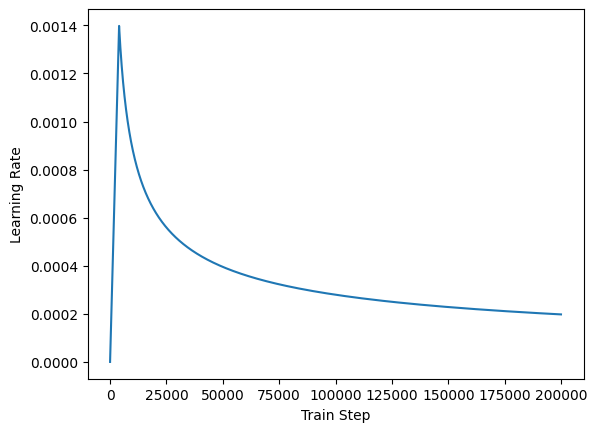

In [26]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [27]:
# 옵티마이저 설정
learning_rate = CustomSchedule(D_MODEL) # D_MODEL은 모델 차원 수에 따라 설정해야 합니다.

optimizer = tf.keras.optimizers.Adam(
    learning_rate=CustomSchedule(D_MODEL),
    beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

### 모델 컴파일 및 학습

- 정의된 모델을 컴파일하고 데이터를 사용하여 학습시킵니다.

In [28]:
# 학습/검증 데이터셋 분리
val_size = int(0.1 * len(dataset))  # 10%를 검증용으로 사용
train_dataset = dataset.skip(val_size)
val_dataset = dataset.take(val_size)

In [29]:
# 모델 컴파일
model.compile(optimizer=optimizer, 
              loss=loss_function, 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

# 모델 학습
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('transformer_ckpt.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True) # 안정적인 학습을 위해 patience 수정 (3->5)
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,  
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1760456138.658576      60 service.cc:148] XLA service 0x79d1e4002ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760456138.659601      60 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1760456138.659620      60 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1760456143.166169      60 assert_op.cc:38] Ignoring Assert operator compile_loss/loss_function/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1760456146.229870      60 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1760456182.231775      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.0129 - loss: 8.7936

W0000 00:00:1760456205.989630      60 assert_op.cc:38] Ignoring Assert operator compile_loss/loss_function/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.0130 - loss: 8.7915

W0000 00:00:1760456248.563772      62 assert_op.cc:38] Ignoring Assert operator compile_loss/loss_function/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


167/167 ━━━━━━━━━━━━━━━━━━━━ 203s 423ms/step - accuracy: 0.0131 - loss: 8.7895 - val_accuracy: 0.0641 - val_loss: 7.7003
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.0471 - loss: 7.4029 - val_accuracy: 0.0648 - val_loss: 6.2960
Epoch 3/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 143ms/step - accuracy: 0.0652 - loss: 6.1475 - val_accuracy: 0.0678 - val_loss: 5.5842
Epoch 4/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.0668 - loss: 5.5309 - val_accuracy: 0.0704 - val_loss: 5.1471
Epoch 5/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.0708 - loss: 5.1310 - val_accuracy: 0.0714 - val_loss: 4.8817
Epoch 6/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.0719 - loss: 4.8497 - val_accuracy: 0.0734 - val_loss: 4.5353
Epoch 7/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.0741 - loss: 4.5497 - val_accuracy: 0.0776 - val_loss: 4.2421
Epoch 8/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 24s 142ms/step - accuracy: 0.0766 - loss: 4.30

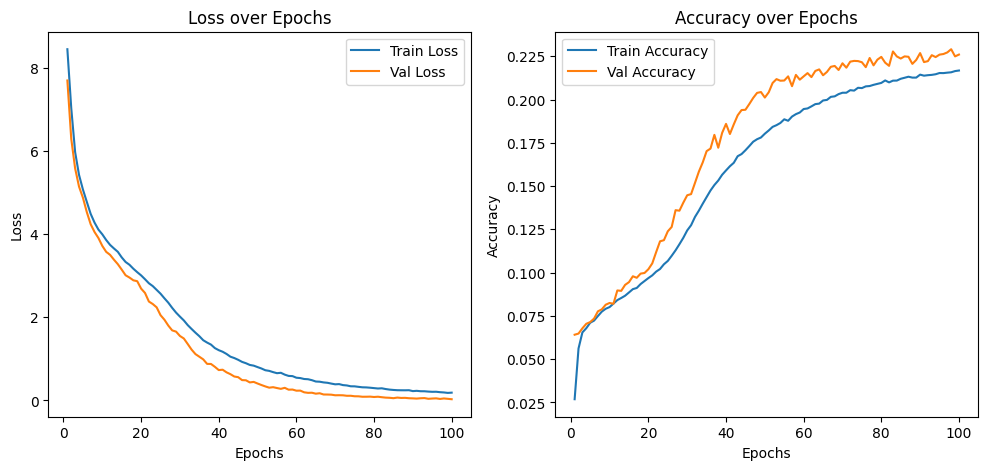

In [30]:
import matplotlib.pyplot as plt

# 학습 로그(history)에서 loss와 accuracy 가져오기
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history.get('val_loss')
val_acc = history.history.get('val_accuracy')

epochs_range = range(1, len(train_loss) + 1)

# Loss 시각화
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_loss, label='Train Loss')
if val_loss:
    plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy 시각화
plt.subplot(1,2,2)
plt.plot(epochs_range, train_acc, label='Train Accuracy')
if val_acc:
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

학습 이력

1. epoch 20 설정 >> accuracy: 0.1352 - loss: 1.9847 - val_accuracy: 0.1540 - val_loss: 1.5961
2. epoch 40 설정 >> accuracy: 0.2086 - loss: 0.3111 - val_accuracy: 0.2247 - val_loss: 0.0826
    - epoch 37에서 학습 멈춤. 쳇봇 테스트 결과 엉망.
3. epoch 100 설정 >> accuracy: 0.2222 - loss: 0.0688 - val_accuracy: 0.2250 - val_loss: 0.0042
    - epoch 98에서 학습 멈춤. 여전히 쳇봇 테스트 결과는 엉망입니다.
    - 교사학습을 사용했지만 여전히 모델 성능에 유의미한 결과를 얻기는 무리인 것 같아보입니다.
    - 이에, 우선 sentence 전처리 함수를 보강하였습니다.
4. 전처리 함수 보강 후 epoch 100회 학습 >> accuracy: 0.2154 - loss: 0.2265 - val_accuracy: 0.2264 - val_loss: 0.0479
    - epoch 59에서 학습  멈춤.
    - 여전히 쳇봇 테스트 결과는 모델 성능과 별개로 엉망입니다. 
5. LAYERS 8, D_MODEL 512 설정 >> accuracy: 0.2243 - loss: 0.0613 - val_accuracy: 0.2255 - val_loss: 0.0096
    - epoch 69에서 학습 멈춤
6. LAYERS 8, D_MODEL 256 설정 >> accuracy: 0.2259 - loss: 0.0320 - val_accuracy: 0.2287 - val_loss: 0.0040
7. LAYERS 6, D_MODEL 512 설정 >> accuracy: 0.2049 - loss: 0.3943 - val_accuracy: 0.2159 - val_loss: 0.1373

## Step 5. 모델 평가하기


### LMS 버전 테스트 코드

In [31]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력 문장을 정수 인코딩 후 START/END 토큰 추가
    sentence = tf.expand_dims(
        tf.constant(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, dtype=tf.int32), axis=0
    )

    # 디코더 초기 입력
    output_sequence = tf.expand_dims(tf.constant(START_TOKEN, dtype=tf.int32), 0)
    MAX_LENGTH = 31
    for i in range(MAX_LENGTH):
        predictions = model(
            inputs={'inputs': sentence, 'dec_inputs': output_sequence},
            training=False
        )
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)


In [32]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [33]:
sentence_generation('안녕')

입력 : 안녕
출력 : 


''

In [34]:
sentence_generation('반가워')

입력 : 반가워
출력 : 


''

In [35]:
sentence_generation('안녕?')

입력 : 안녕?
출력 : 


''

In [36]:
sentence_generation('안녕 ㅠㅠ')

입력 : 안녕 ㅠㅠ
출력 : 


''

In [37]:
sentence_generation('나랑 친구해줄래?')

입력 : 나랑 친구해줄래?
출력 : 


''

### top-k 샘플링 및 반복 방지용 temperature 적용

In [38]:
import tensorflow as tf
import numpy as np

def sentence_generation_advanced(sentence, max_length=31, temperature=1.0, top_k=50, top_p=0.9, repetition_penalty=1.2):
    """
    입력 문장 -> 모델이 생성한 문장 반환
    Args:
        sentence (str): 입력 문장
        max_length (int): 생성 최대 길이
        temperature (float): 확률 분포 샤프닝
        top_k (int): 상위 k개 단어만 고려
        top_p (float): 누적 확률 top-p만 고려 (nucleus sampling)
        repetition_penalty (float): 반복 단어 패널티 (>1: 반복 억제)
    """
    
    # 1️⃣ 문장 전처리
    sentence = preprocess_sentence(sentence)
    
    # 2️⃣ 인코더 입력
    encoder_input = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 3️⃣ 디코더 입력 초기화
    decoder_input = tf.constant([START_TOKEN[0]], shape=(1,1), dtype=tf.int32)
    
    # 4️⃣ 생성된 단어 기록
    generated_ids = [START_TOKEN[0]]
    
    for _ in range(max_length):
        # 모델 호출
        predictions = model(inputs={'inputs': encoder_input, 'dec_inputs': decoder_input}, training=False)
        logits = predictions[:, -1, :].numpy().flatten()
        
        # 4-1️⃣ 반복 단어 패널티 적용
        for token_id in set(generated_ids):
            logits[token_id] /= repetition_penalty
        
        # 4-2️⃣ temperature 적용
        logits = logits / temperature
        
        # 4-3️⃣ top-k 필터링
        if top_k > 0:
            indices_to_remove = logits < np.sort(logits)[-top_k]
            logits[indices_to_remove] = -np.inf
        
        # 4-4️⃣ top-p(nucleus) 필터링
        if top_p < 1.0:
            sorted_indices = np.argsort(logits)[::-1]
            sorted_logits = logits[sorted_indices]
            cumulative_probs = np.cumsum(tf.nn.softmax(sorted_logits).numpy())
            cutoff = np.where(cumulative_probs > top_p)[0]
            if len(cutoff) > 0:
                sorted_logits[cutoff[0]+1:] = -np.inf
            # 원래 logits 배열에 반영
            logits[sorted_indices] = sorted_logits
        
        # 4-5️⃣ 다음 단어 샘플링
        probs = tf.nn.softmax(logits).numpy()
        next_token = np.random.choice(len(probs), p=probs)
        
        # 종료 토큰이면 종료
        if next_token == END_TOKEN[0]:
            break
        
        # 디코더 입력 업데이트
        decoder_input = tf.concat([decoder_input, [[next_token]]], axis=-1)
        generated_ids.append(next_token)
    
    # 5️⃣ START/END 토큰 제거 후 디코딩
    predicted_sequence = [idx for idx in generated_ids if idx not in START_TOKEN + END_TOKEN]
    predicted_sentence = tokenizer.decode(predicted_sequence)
    
    return predicted_sentence


In [39]:
# 테스트 입력 문장
test_sentences = [
    "안녕",
    "나랑 친구해줄래?",
    "오늘 기분 어때?",
    "너는 뭐하고 있어?",
    "재밌는 영화 추천해줄래?"
]

# 생성 문장 출력
for sentence in test_sentences:
    predicted = sentence_generation_advanced(
        sentence,
        max_length=31,
        temperature=0.8,
        top_k=50,
        top_p=0.9,
        repetition_penalty=1.2
    )
    print("입력 :", sentence)
    print("출력 :", predicted)
    print("-"*50)


입력 : 안녕
출력 : 
--------------------------------------------------
입력 : 나랑 친구해줄래?
출력 : 쥐
--------------------------------------------------
입력 : 오늘 기분 어때?
출력 : 
--------------------------------------------------
입력 : 너는 뭐하고 있어?
출력 : 
--------------------------------------------------
입력 : 재밌는 영화 추천해줄래?
출력 : 
--------------------------------------------------


총평

- 보다 일반적인 결과를 보고자 custom으로 구현한 방식이 아닌 keras 내장함수를 활용하여 챗봇 만들기를 진행하였습니다.
- 배운 지식을 토대로 다양한 방식으로 학습을 시도했지만, 틀린 정답을 반복적으로 학습하는 모습을 관찰했습니다.
- 이번 경험을 통해 교사학습(Supervised Learning)의 필요성을 직접 체감할 수 있었습니다.
- 혼자 실험을 진행하며 학습이 원활하지 않았던 이유로는 다음과 같은 가능성을 생각해볼 수 있습니다:
    - 한국어의 교착어 특성 때문에 subword 기반 토큰화가 항상 적절하지 않을 수 있음
    - 데이터셋 품질이나 양의 문제도 학습 성능에 영향을 미쳤을 가능성
- 향후에는 데이터 전처리 개선, 토큰화 전략 다양화, 그리고 teacher forcing을 활용한 학습을 시도해 보는 것이 필요할 것 같습니다.